# Demonstration of probablistic regression using Tensorflow Probability

In [1]:
# import packages
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns

In [35]:
# Create negloglik function
def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

## Toy example of simple linear regression

Generate some fake simple linear data

In [2]:
from sklearn.datasets import make_regression

In [20]:
rng = np.random.default_rng(42)

Create fake data by drawing samples from a standard normal distribution

<AxesSubplot: >

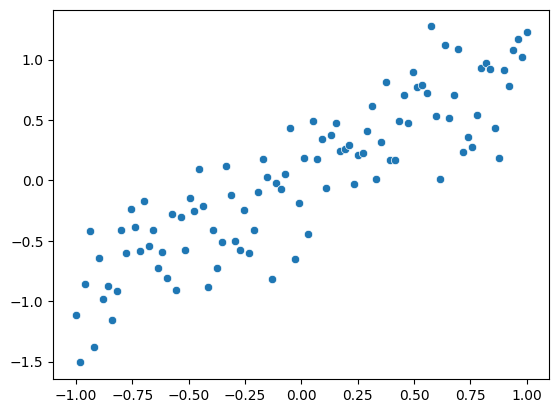

In [28]:
coeff = 0.3
x = np.linspace(-1, 1, 100)[:, None]  # For batch purposes
y = x + coeff * rng.normal(size=100)[:, None]
sns.scatterplot(x=x.flatten(), y=y.flatten())

### Probabilistic regression with defined variance and learned mean

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=(1, )),
    tfp.layers.DistributionLambda(
        lambda t: tfp.distributions.Independent(
            tfp.distributions.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1
    ))
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
 distribution_lambda_1 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=20, verbose=False)

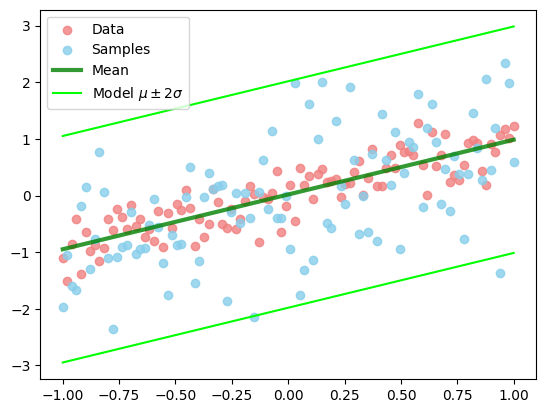

In [71]:
# Plot results
y_model = model(x)
y_sample = y_model.sample().numpy().ravel()  # Take samples from distribution
y_hat = y_model.mean().numpy().ravel()
y_std = y_model.stddev().numpy().ravel()
plt.scatter(x=x.ravel(), y=y.ravel(), color="lightcoral", alpha=0.8, label="Data")
plt.scatter(x=x.ravel(), y=y_model.sample().numpy().ravel(), color="skyblue", alpha=0.8, label="Samples")
plt.plot(x.ravel(), y_hat, color="green", lw=3, label="Mean", alpha=0.8)
plt.plot(x.ravel(), y_hat + 2*y_std, color="lime", label="Model $\mu \pm 2 \sigma$")
plt.plot(x.ravel(), y_hat - 2*y_std, color="lime")
plt.legend();
#plt.lineplot(x=x.ravel(), y=y_sample.mean())

As can be seen from the above plot, setting a constant variance makes the model unable to learn the actual spread of the data. Thus, it is beneficial to learn the variance as well.

### Probabilistic regression with learned variance and mean

In [72]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=2, input_shape=(1, )),
    tfp.layers.DistributionLambda(
        lambda t: tfp.distributions.Independent(
            tfp.distributions.Normal(
                loc=t[..., :1], # First output of dense layer parameterize the mean
                scale=tf.math.softplus(t[..., 1:])  # Second output parameterize the stddev, using softmax to ensure positive!
            ),
            reinterpreted_batch_ndims=1
    ))
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2)                 4         
                                                                 
 distribution_lambda_2 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


Note the 2 units in the `Dense` layer, allowing for outputting a *mean* and *variance*. Additionally, using the `softmax` function ensures a positive standard deviation which is trainable. However, this method of creating the model is quite verbose. A better method is to use the wrapper functions of tensorflow as follows:

In [77]:
event_shape = 1 # The size of the output
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=tfp.layers.IndependentNormal.params_size(event_shape), input_shape=(1, )),
    tfp.layers.IndependentNormal(event_shape=event_shape)  # Uses softmax function as default for parameterizing loc 
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2)                 4         
                                                                 
 independent_normal_1 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


Note that the `IndependentNormal` layer uses the `softmax` function for the standard devation as default

In [80]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=100, verbose=False)

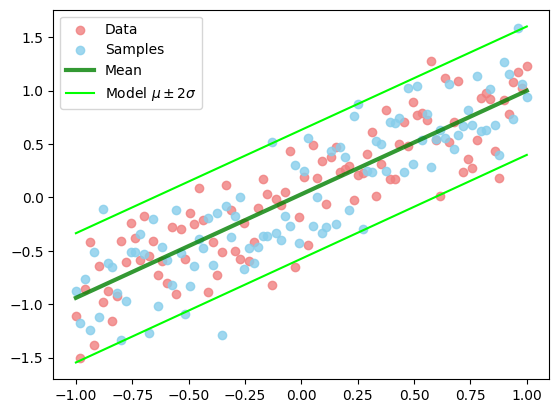

In [83]:
# Plot results
y_model = model(x)
y_sample = y_model.sample().numpy().ravel()  # Take samples from distribution
y_hat = y_model.mean().numpy().ravel()
y_std = y_model.stddev().numpy().ravel()
plt.scatter(x=x.ravel(), y=y.ravel(), color="lightcoral", alpha=0.8, label="Data")
plt.scatter(x=x.ravel(), y=y_model.sample().numpy().ravel(), color="skyblue", alpha=0.8, label="Samples")
plt.plot(x.ravel(), y_hat, color="green", lw=3, label="Mean", alpha=0.8)
plt.plot(x.ravel(), y_hat + 2*y_std, color="lime", label="Model $\mu \pm 2 \sigma$")
plt.plot(x.ravel(), y_hat - 2*y_std, color="lime")
plt.legend();

Here, the model also has a learned $\sigma^2$, thus better encapsulating the spread of the data.

### The DenseVariational Layer

Posterior distribution captures our belief over which weights are most likely given the data - *epistemic uncertainty*

#### Variational Inference with BayesByBackdrop

**1**: Defining priors
* Represents belief about which parameter distributions are likely before we have seen any data
* Standard assumption: *spherical gaussian*
    * Ie: independent normal distribution for each weight and bias all with equal variance.
* Can have no trainable variables<br>

**2**: Defining posterior
* `VariableLayer`: returns tf varaiable when called regardless of input 
* `IndependentNormal`: Define distribution over dense layer parameters
    * By default, the output samples from the distribution in order to get concrete tensors for the forward passing in gradient descent <br> 

**3**: Defining model
* `DenseVariational`: Requires functions defining posterior and prior functions. Also requires
* Weighting of kl: Usually divide by the number of samples
    * The loss function is a sum of two parts: the actual training loss and the KL divergence. As the KL divergence does not depend on the data, it must include a weight to make it unbiased.
    * Want to maximize ELBO. Due to minibatches, must weight the KL term in the ELBO to get unbiased estimate


### Example

<AxesSubplot: >

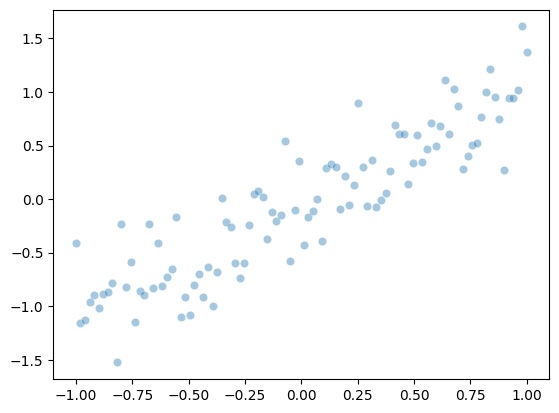

In [343]:
# Create training data
coeff = 0.3
x = np.linspace(-1, 1, 100)[:, None]  # For batch purposes
y = x + coeff * rng.normal(size=100)[:, None]
sns.scatterplot(x=x.flatten(), y=y.flatten(), alpha=0.4)

Given that we only have a sample of the data, there are multiple functions that could have generated this data. For instance, the line $y_i = x_i + 0.1\epsilon_i$ could very well have generated this data if one only has the given sample. Thus, we want to capture this *epistemic* uncertainty using *Variational Inference* with uncertainty on the weights.<br>

In this case, there is an uncertainty on the *slope* and the *intercept* corresponding to the uncertainty on the weights.

**Create prior and posterior distribution for model weights**

In [340]:
# Define prior weight distribution as 
# non-trainable standard normally distributed

# Returns distribution for weights in that layer
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size  # Number of parameters in that layer
    # Return distribution of those weights
    prior_model = tf.keras.models.Sequential([
        tfp.layers.DistributionLambda(
            lambda t : tfd.MultivariateNormalDiag(
                loc=tf.zeros(n), scale_diag = tf.ones(n)
            )
        )
    ])
    return prior_model

The variational posterior is the posterior we assume the model weights adhere to.

In [341]:
# Define posterior as multivariate Gaussina
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    # Trainable parameters
    posterior_model = tf.keras.models.Sequential([
        tfp.layers.VariableLayer(
            tfp.layers.MultivariateNormalTriL.params_size(n),
            dtype=dtype
        ),
        tfp.layers.MultivariateNormalTriL(n)
    ])
    return posterior_model

**Create model with `DenseVariational` layers**

In [344]:
model = tf.keras.models.Sequential([
    tfp.layers.DenseVariational(
        input_shape=(1,),
        units=1,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        kl_weight=1/x.shape[0],
        kl_use_exact=True  # Can use exact as using multivariate gaussian
    )
])

model.compile(loss=tf.keras.losses.MeanSquaredError(), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005)
             )
model.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_74 (Dense  (None, 1)                5         
 Variational)                                                    
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [345]:
# Fit the model
model.fit(x, y, epochs=500, verbose=False)

Check out the parameters of the prior and posterior distribution

In [352]:
dummy_input = np.array([0])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:\t\t\t', model_prior.mean().numpy())
print('prior variance:\t\t\t', model_prior.variance().numpy())
print('posterior mean:\t\t\t', model_posterior.mean().numpy())
print('posterior covariance:\t\t', model_posterior.covariance().numpy()[0])
print('\t\t\t\t', model_posterior.covariance().numpy()[1])

prior mean:			 [0. 0.]
prior variance:			 [1. 1.]
posterior mean:			 [ 1.052303   -0.04939226]
posterior covariance:		 [0.01776362 0.00236377]
				 [0.00236377 0.00611898]


Notice the 5 parameters. It consists of the mean of the slope and y intercept, the variances of both and the covariance between them.<br>
As the prior was not trainable, the mean and variance is defined by us. Let's plot the results:

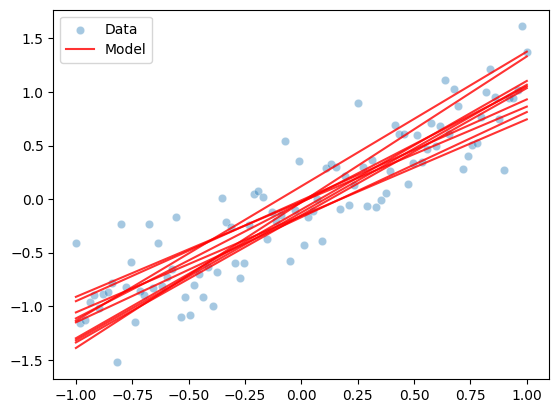

In [360]:
x_plot = x.flatten()
y_plot = y.flatten()
sns.scatterplot(x=x_plot, y=y_plot, alpha=0.4, label="Data")
for _ in range(10):
    y_model = model(x).numpy().flatten()
    label = "Model" if _ == 0 else None
    sns.lineplot(x=x_plot, y=y_model, color="red", label=label, alpha=0.8)

The above plot shows an *ensemble of lines* that could have generated the data, thus capturing the epistemic uncertainty.

**Expore effect of sample size on epistemic uncertainty**
One of the characteristics of epistemic uncertainty is that it decreases when you add more data, as demonstrated below 

<AxesSubplot: >

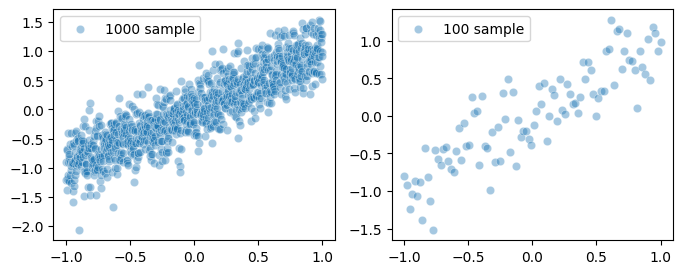

In [369]:
# Create two datasets
# Create training data
coeff = 0.3
x_1000 = np.linspace(-1, 1, 1000)[:, None]  # For batch purposes
y_1000 = x_1000 + coeff * rng.normal(size=1000)[:, None]

x_100 = np.linspace(-1, 1, 100)[:, None]  # For batch purposes
y_100 = x_100 + coeff * rng.normal(size=100)[:, None]

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sns.scatterplot(x=x_1000.flatten(), y=y_1000.flatten(), alpha=0.4, label="1000 sample", ax=axs[0])
sns.scatterplot(x=x_100.flatten(), y=y_100.flatten(), alpha=0.4, label="100 sample", ax=axs[1])

In [371]:
# Create models
model_1000 = tf.keras.models.Sequential([
    tfp.layers.DenseVariational(
        units=1,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        kl_weight=1/1000
    )
])

model_100 = tf.keras.models.Sequential([
    tfp.layers.DenseVariational(
        units=1,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        kl_weight=1/100
    )
])

model_1000.compile(loss=tf.keras.losses.MeanSquaredError(), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005)
             )

model_100.compile(loss=tf.keras.losses.MeanSquaredError(), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005)
             )

In [372]:
# Fit models
model_1000.fit(x, y, epochs=500, verbose=False)
model_100.fit(x, y, epochs=500, verbose=False)

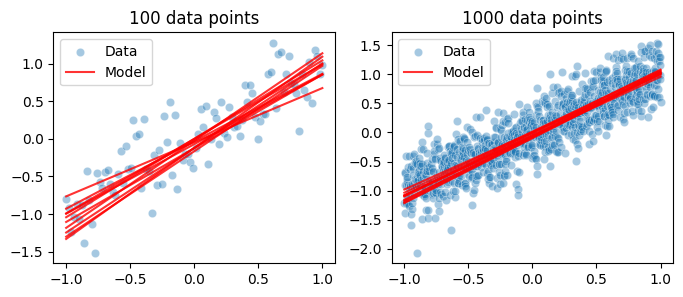

In [376]:

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for i, ax in enumerate(axs.ravel()):
    if i == 0:
        x_plot = x_100.flatten()
        y_plot = y_100.flatten()
        ax.set_title("100 data points")
    else:
        x_plot = x_1000.flatten()
        y_plot = y_1000.flatten()
        ax.set_title("1000 data points")
    sns.scatterplot(x=x_plot, y=y_plot, alpha=0.4, label="Data", ax=ax)
    for _ in range(10):
        if i == 0:
            y_model = model_100(x_100).numpy().flatten()
        else:
            y_model = model_1000(x_1000).numpy().flatten()
        label = "Model" if _ == 0 else None
        sns.lineplot(x=x_plot, y=y_model, color="red", label=label, alpha=0.8, ax=ax)
    

## Combining aleatoric and epistemic uncertainty

<AxesSubplot: >

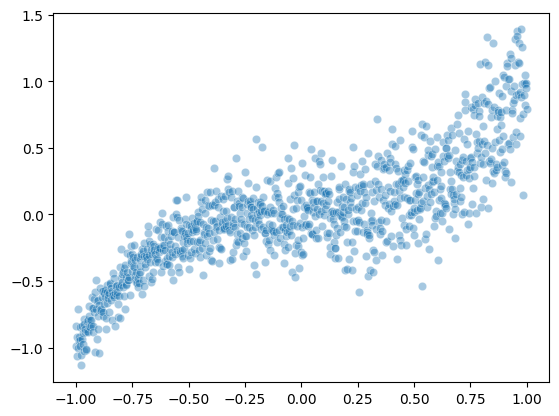

In [412]:
# Create data
x = np.linspace(-1, 1, 1000)[:, None]
y = x**3 + 0.1*(2+x)*rng.normal(size=1000)[:, None]
sns.scatterplot(x=x.flatten(), y=y.flatten(), alpha=0.4)

In [416]:
model = tf.keras.models.Sequential([
    tfp.layers.DenseVariational(
        input_shape=(1,),
        units=8,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        kl_weight=1/x.shape[0],
        activation=tf.nn.elu
    ),
    tfp.layers.DenseVariational(
        units=tfp.layers.IndependentNormal.params_size(1),
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        kl_weight=1/x.shape[0],
    ),
    tfp.layers.IndependentNormal(1)  # Aleatoric part
])

model.compile(loss=negloglik, 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005)
             )
model.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_83 (Dense  (None, 8)                152       
 Variational)                                                    
                                                                 
 dense_variational_84 (Dense  (None, 2)                189       
 Variational)                                                    
                                                                 
 independent_normal_4 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [417]:
# Fit model
model.fit(x, y, epochs=1000, verbose=False)
model.evaluate(x, y)

32/32 [==============================] - 1s 2ms/step - loss: -0.0540


-0.05398814380168915

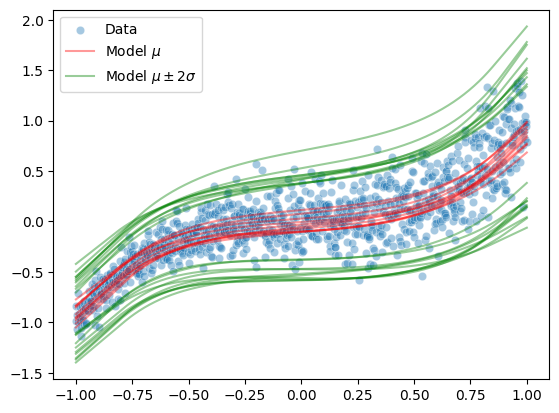

In [427]:
# Plot resultsx_plot = x.flatten()
x_plot = x.flatten()
y_plot = y.flatten()
sns.scatterplot(x=x_plot, y=y_plot, alpha=0.4, label="Data")
for _ in range(10):
    y_model = model(x)
    y_mean = y_model.mean().numpy().flatten()
    y_std = y_model.stddev().numpy().flatten()
    y_m2sd = y_mean - 2*y_std
    y_p2sd = y_mean + 2*y_std
    
    label_model = "Model $\mu$" if _ == 0 else None
    label_al = "Model $\mu \pm 2 \sigma$" if _ == 0 else None
    sns.lineplot(x=x_plot, y=y_mean, color="red", label=label_model, alpha=0.4)
    sns.lineplot(x=x_plot, y=y_m2sd, color="green", label=label_al, alpha=0.4)
    sns.lineplot(x=x_plot, y=y_p2sd, color="green", alpha=0.4)
    

The above plot shows the aleatoric and epistemic uncertainty as follows:
* The dots doesn't need to lie exactly on the mean, ie, it outputs a distribution $\longrightarrow$ *aleatoric uncertainty*
* The mean and variance is uncertain $\longrightarrow$ *epistemic uncertainty*

# Normalizing flows

## Bijectors

Can be used as invertible functions to compute forward and inverse transformation of input tensors. Additionally, they can be used to transform random variables and compute events under this new distribution.  

In [445]:
# Example
tfb = tfp.bijectors

normal = tfd.Normal(loc=0., scale=1.)

# Draw three samples from standard normal distribution
z = normal.sample(3)
print(z)

# Create transformation chain
scale_and_shift = tfb.Chain([tfb.Shift(1.), tfb.Scale(2.)])

# Apply transformation to the samples
x = scale_and_shift.forward(z)
print(x)

# Compute logprob of x
log_prob_x = normal.log_prob(z) - scale_and_shift.forward_log_det_jacobian(z, event_ndims=0)
log_prob_x

tf.Tensor([-0.99107707  0.49052605  0.55982465], shape=(3,), dtype=float32)
tf.Tensor([-0.98215413  1.9810522   2.1196494 ], shape=(3,), dtype=float32)


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2.1032026, -1.7323936, -1.7687875], dtype=float32)>

### Example

**Define base distribution and draw samples**

In [448]:
# Define base distribution
normal = tfd.Normal(loc=0., scale=1.)

# Sample from distribution
n = 10000
z = normal.sample(n)

**Scale and shift bijector**

In [451]:
# Define scale and shift
scale = 4.5
shift = 7

# Define chain bijector
scale_and_shift = tfb.Chain([tfb.Shift(shift), tfb.Scale(scale)])

In [452]:
# Apply forward transformation
x = scale_and_shift.forward(z)

**Plots**

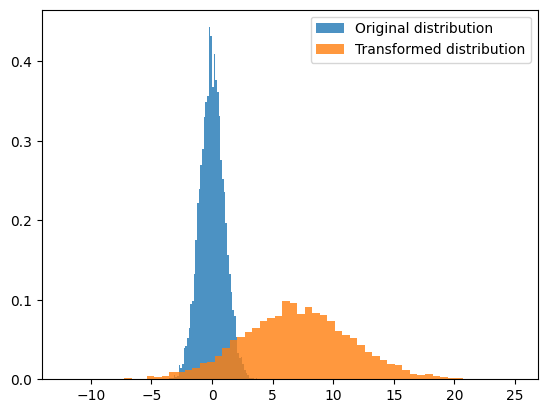

In [455]:
plt.hist(z, bins=60, density=True, label="Original distribution", alpha=0.8)
plt.hist(x, bins=60, density=True, label="Transformed distribution", alpha=0.8)
plt.legend();

In [458]:
# Check inverse transformation equal to z
inv_x = scale_and_shift.inverse(x)
(inv_x.numpy() == z.numpy()).all()

True

## Autoregressive flows

Assume the data is distributed and ordered as follows:
$$z\sim N(0,I)$$ 
$$x[i] = z[i] * scale(x[0: i-1]) + loc(x[0: i-1]), \qquad i = 0,...,D-1$$
The conditional distribution of each feature $x_i$ is modelled as Gaussian distribution where the mean and standard deviation are functions of the features $x_0$ to $x_{i-1}$.<br>

**Example creating the flow:**

In [460]:
# Specify the architecture
made = tfb.AutoregressiveNetwork(
    params=2, event_shape=[3], hidden_units=[16,16], activation="sigmoid"
)
# Inputs of length 3, output of length input + size 2
made(tf.random.normal([2, 3]))

<tf.Tensor: shape=(2, 3, 2), dtype=float32, numpy=
array([[[ 0.        ,  0.        ],
        [ 0.20580842, -0.73648447],
        [-0.07031493, -0.51815116]],

       [[ 0.        ,  0.        ],
        [ 0.20726882, -0.7355534 ],
        [-0.08761426, -0.5241368 ]]], dtype=float32)>

This corresponds to creating two batches with three features with both the mean and standard deviation

In [465]:
# Create bijector
maf_bijector = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

normal = tfd.Normal(loc=0, scale=1)
maf = tfd.TransformedDistribution(normal, maf_bijector)
maf

<tfp.distributions._TransformedDistribution 'masked_autoregressive_flowNormal' batch_shape=[] event_shape=[] dtype=float32>

### Example

In [476]:
# Load dataset
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n, noise=0.05)
X, y = noisy_moons
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]

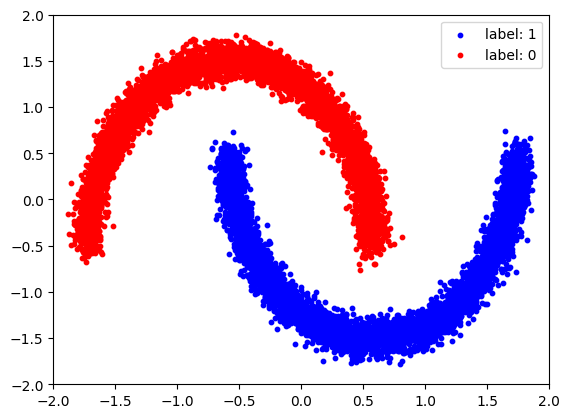

In [477]:
# Plot with labels
y_label = y.astype(np.bool_)
X_train, Y_train = X_data[..., 0], X_data[..., 1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color="blue")
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color="red")
plt.legend(["label: 1", "label: 0"])
plt.xlim(xlim)
plt.ylim(ylim);

In [478]:
# Define base distribution
base_distribution = tfd.Normal(loc=0, scale=1)

In [481]:
# Define the trainable distribution

def make_masked_autoregressive_flow(hidden_units=[16,16], activation="relu"):
    made = tfb.AutoregressiveNetwork(
        params=2, event_shape=[2], hidden_units=hidden_units, 
        activation=activation
    )
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

trainable_distribution = tfd.TransformedDistribution(base_distribution,
                                                     make_masked_autoregressive_flow(),
                                                    )

## Epistemic uncertainty.ipynb_checkpoints/

<AxesSubplot: >

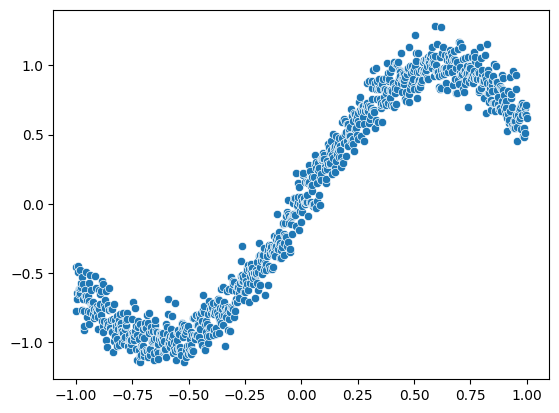

In [254]:
# Create data
# Generation of y samples
# Goal: becomes more spread out/noisy as x increases
x = np.linspace(-1, 1, 1000)
noise = rng.normal(size=1000) #* (1 + (x/2))
period_div = 2.5
y = np.sin(x*period_div) + noise/10
sns.scatterplot(x=x, y=y)

### Probabilistic regression with constant variance and learned mean

In [118]:
def create_train_test_split(x, y, train_size=0.7):
    train_size = 0.7
    pos = int(np.ceil(len(x)*train_size))
    rand_ind = rng.permutation(np.arange(len(x)))
    idx_train = rand_ind[:pos]
    idx_test = rand_ind[pos:]
    x_train = x[idx_train]
    y_train = y[idx_train]
    x_test = x[idx_test]
    y_test = y[idx_test]
    return x_train, x_test, y_train, y_test

In [237]:
tfd = tfp.distributions
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-3 + 0.005*tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])


def prior(kernel_size, bias=0, dtype=None):
    n = kernel_size + bias
    return tfp.layers.DistributionLambda(
        lambda t: tfp.distributions.Normal(loc=tf.zeros(n), scale=tf.ones(n))
    )

In [255]:
train_size = 0.7
x_train, x_test, y_train, y_test = create_train_test_split(x, y, train_size=train_size)

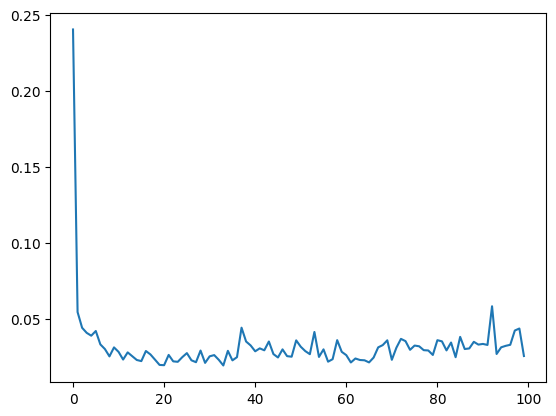

In [328]:
lr = 5e-3
n_epochs=100

model = tf.keras.models.Sequential([
    #tf.keras.layers.Dense(units=32, activation=tf.nn.elu, kernel_initializer="he_normal"),
    tf.keras.layers.Dense(units=32, activation=tf.nn.elu, kernel_initializer="he_normal"),
    tfp.layers.DenseVariational(
        units=64,
        make_prior_fn=prior,
        make_posterior_fn=posterior_mean_field,
        kl_weight=1/(len(x_train)),
        activation=tf.nn.elu,
    ),
    tfp.layers.DenseVariational(
        units=32, 
        make_prior_fn=prior, 
        make_posterior_fn=posterior_mean_field, 
        kl_weight = 1/(len(x_train)),
        activation=tf.nn.elu
        ),
    tfp.layers.DenseVariational(
        units=1, 
        make_prior_fn=prior, 
        make_posterior_fn=posterior_mean_field, 
        kl_weight = 1/(len(x_train)),
        ),
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr), metrics=["mse"])
history = model.fit(x=x_train[:, None], y=y_train[:, None], batch_size=32, epochs=n_epochs, verbose=0)#, callbacks=[callback])
plt.plot(range(len(history.epoch)), history.history["mse"])

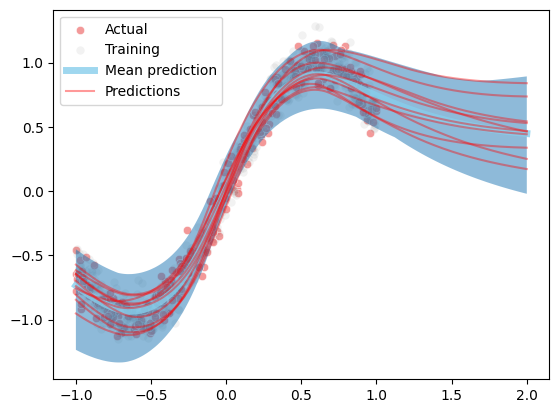

In [329]:
predictions = np.zeros((100, x_test.shape[0]+100))
x_sped = np.concatenate([x_test, np.linspace(1, 2, 100)])
for i in range(100):
    predictions[i] = model(x_sped).numpy().flatten()
ax = sns.scatterplot(x=x_test, y=y_test, label="Actual", color="lightcoral", alpha=0.8)
sns.scatterplot(x=x_train, y=y_train, label="Training", color="grey", alpha=0.1)
sns.lineplot(x=x_sped, y=predictions.mean(axis=0), label="Mean prediction", color="skyblue", alpha=0.8, lw=5)
for i, pred in enumerate(predictions[:10]):
    label = "Predictions" if i == 0 else None
    sns.lineplot(x=x_sped, y=pred, label=label, color="red", alpha=0.4)
    
mins = predictions.min(axis=0)
maxs = predictions.max(axis=0)
idx = np.argsort(x_sped)
ax.fill_between(x_sped[idx], mins[idx], maxs[idx], alpha=0.5)
plt.legend(loc="upper left");

(400,)